# Simulation analysis of neutrons from DD source into LZ LXeTPC  

No Energy Selection on Neutrons

## Read Data and Basics

In [2]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

import uproot
import scipy
import awkward as ak

import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt

In [102]:
#file = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_root_135458397.root' #10000 events
#file = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_root_35547824.root' #20000 
#file = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_root_75620945.root' #100000
file = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_root_322888360.root' #200000

In [103]:
content = uproot.open(file)
print(f'Trees inside file: {content.keys()}')

Trees inside file: ['Events;8', 'Events;7', 'RunHeader;1']


In [104]:
runheader = content["RunHeader"].arrays() #run-level information
events = content["Events;8"].arrays() #event information 

In [105]:
#function to list processes by their index (which changes with each file)
def list_processes():
    processID = runheader['runHeader.processIndexes'][0]
    processes = runheader['runHeader.processNames'][0]
    
    for i in range(len(runheader['runHeader.processIndexes'][0])):
        print('Process #{0}: {1}'.format(processID[processID==i][0], processes[processID==i][0]))
    return

In [106]:
list_processes()

Process #0: RadioactiveDecay
Process #1: Rayl
Process #2: Transportation
Process #3: compt
Process #4: eIoni
Process #5: ionIoni
Process #6: msc
Process #7: neutronInelastic
Process #8: phot
Process #9: eBrem
Process #10: hadElastic
Process #11: annihil
Process #12: conv
Process #13: nCapture


In [107]:
print(f'Number of events: {len(events["header.eventId"])}')

Number of events: 200000


In [108]:
#function to find a processid given a process name 
def find_processes(name):
    processID = runheader['runHeader.processIndexes'][0]
    processes = runheader['runHeader.processNames'][0]
    
    for i in range(len(runheader['runHeader.processIndexes'][0])):
        if processes[i] == name:
            return processID[i]
        

In [109]:
neutronInelasticId = find_processes('neutronInelastic')

In [110]:
#looking at numbers
neutrons_xenon_events = np.array([], dtype=int) #list of eventIds with at least 1 neutron 
num_inelastic_scatter = 0
inelastic_events = np.array([], dtype=int) #list of eventIds where there is a neutronInelastic process 

for i_evt in events['header.eventId']:

    if events[i_evt]['volume.names'].tolist() != []: #particles reach xenon 

        for i_particle, particle in enumerate(events[i_evt]['track.particleNames']):
            if particle == 'neutron':
                neutrons_xenon_events = np.append(neutrons_xenon_events, i_evt)
                
                if events[i_evt]['track.step.processesID'][i_particle][-1] == neutronInelasticId: 
                    inelastic_events = np.append(inelastic_events, i_evt)
                    num_inelastic_scatter +=1

neutrons_xenon_events = np.unique(neutrons_xenon_events)
num_neutrons_xenon = len(neutrons_xenon_events)  

inelastic_events = np.unique(inelastic_events) 

print(f'Events where neutron reached Xenon: {num_neutrons_xenon}/{len(events["header.eventId"])}')
print(f'Number of events with at least one inelastic neutron scatter: {len(inelastic_events)}')
print(f'Total number of inelastic neutron scatters: {num_inelastic_scatter}') 


Events where neutron reached Xenon: 12243/200000
Number of events with at least one inelastic neutron scatter: 7239
Total number of inelastic neutron scatters: 11690


In [111]:
#non-zero
non=0
for i_evt in events['header.eventId']:
    if events[i_evt]['volume.names'].tolist() != []: #particles reach xenon 
        non+=1

In [112]:
non

16252

## Kinetic Energy of Particles with neutronInelastic CreatorProcess

In [131]:
event_names = events[inelastic_events]["track.particleNames"]
event_processes = events[inelastic_events]["track.particleCreatorProcesses"]

In [84]:
#kinetic energies of any particle with neutronInelastic creator process 
p_energy = []

for x in range(len(event_names)):
    for i in range(len(event_names[x])):
        if event_processes[x][i] == 'neutronInelastic':
            p_energy.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step kinetic energies 
            

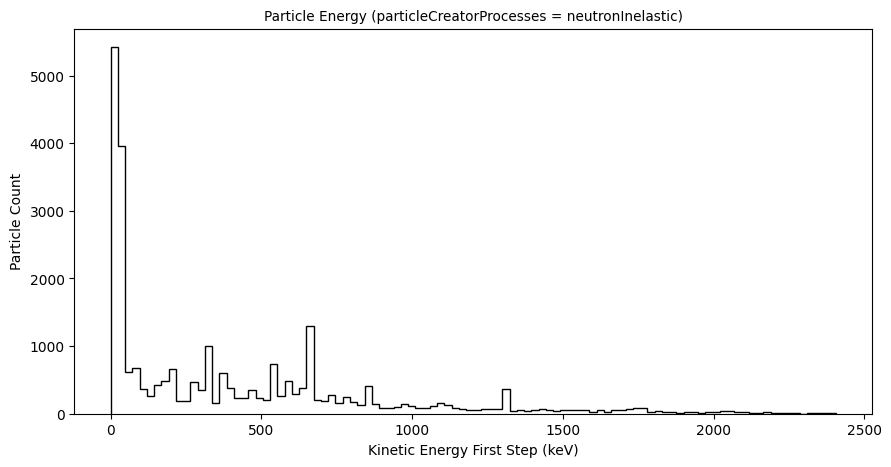

In [85]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(p_energy, 100, histtype='step', color='black')
plt.xlabel('Kinetic Energy First Step (keV)')
plt.ylabel('Particle Count')
plt.title('Particle Energy (particleCreatorProcesses = neutronInelastic)', fontsize=(9.8));

## Kinetic Energies of Gamma Rays Produced in Xenon De-excitation

In [86]:
#find the kinetic energies of gammas released by de-excitation of xenon nuclei to compare to literature
gammas_energy = []

for x in range(len(event_names)):
    for i in range(len(event_names[x])):
        if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
            gammas_energy.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 
            

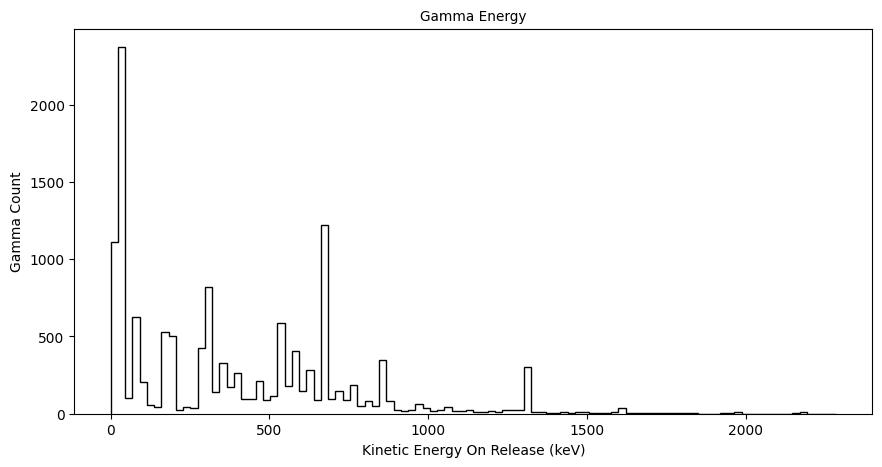

In [87]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 100, histtype='step', color='black')
plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));


In [88]:
#look at which Xenon isotopes neutrons interacted with 

particles = []
for i_evt in inelastic_events:
    #look at neutron inelastic particles only 
    #print(events[i_evt]['track.particleNames'][events[i_evt]['track.particleCreatorProcesses'] == 'neutronInelastic'])
    particles.append(np.array(events[i_evt]['track.particleNames'][events[i_evt]['track.particleCreatorProcesses'] == 'neutronInelastic']))
    
isotopes = []
for particle_array in particles:
    for p in particle_array:
        if p.startswith('Xe'):
            isotopes.append(p)
            
isotopes, counts = np.unique(np.array(isotopes), return_counts=True)

print('Neutrons inelastically scattered from these Xenon isotopes:')
for i in range(len(isotopes)):
    print(f'{isotopes[i]} {counts[i]} occurances') 

    
#Xenon counted matches number of inelastic scatters!
print()
print(f'Number of neutron inelastic scatters: {num_inelastic_scatter}')
print(f'Xenon atoms counted: {np.sum(counts)}') 
print(f'Gammas counted: {len(gammas_energy)}')

Neutrons inelastically scattered from these Xenon isotopes:
Xe124 3 occurances
Xe126 5 occurances
Xe128 87 occurances
Xe129 2399 occurances
Xe130 220 occurances
Xe131 1584 occurances
Xe132 1100 occurances
Xe134 349 occurances
Xe136 227 occurances

Number of neutron inelastic scatters: 5974
Xenon atoms counted: 5974
Gammas counted: 13403


No Xe126 in this analysis - makes sense since lowest amount. Check if seen with more data - with 20,000 events there is a Xe126 scatter

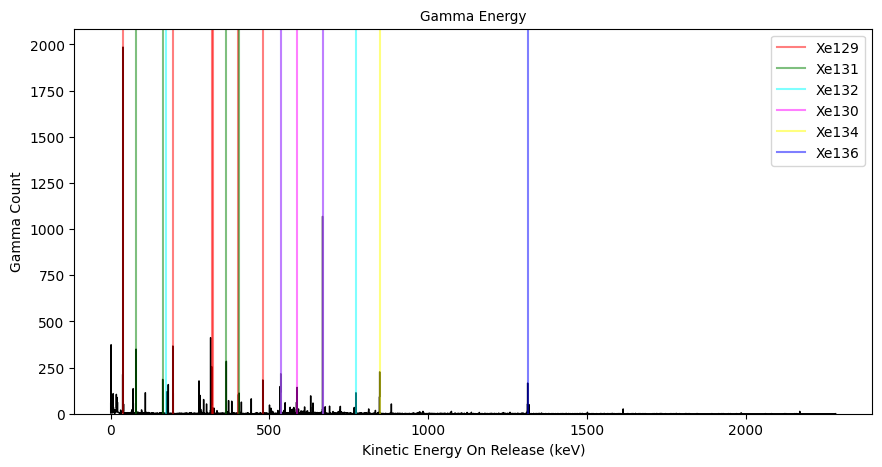

In [89]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 2500, histtype='step', color='black') #2500/200 =  

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));


#plot lines to compare to literature 

#Xe129 
plt.axvline(39.5774, color='red', alpha=0.5, label='Xe129') #3/2+ -> 1/2+ #most prominent 
plt.axvline(196.56, color='red', alpha=0.5) #11/2- -> 3/2+
plt.axvline(318.18, color='red', alpha=0.5) #3/2+ -> 1/2+
plt.axvline(321.7, color='red', alpha=0.5) #5/2+ -> 1/2+
plt.axvline(479.1, color='red', alpha=0.5) #7/2+ -> 3/2+
plt.axvline(402.6, color='red', alpha=0.5) #5/2+ -> 3/2+



#Xe131  
plt.axvline(80.1854, color='green', alpha=0.5, label='Xe131') #most prominent  
plt.axvline(163.93, color='green', alpha=0.5)
plt.axvline(364.489, color='green', alpha=0.5)
plt.axvline(404.814, color='green', alpha=0.5)



#Xe132 
plt.axvline(173.6, color='cyan', alpha=0.5)
plt.axvline(538.1, color='cyan', alpha=0.5, label='Xe132')
plt.axvline(667.75, color='cyan', alpha=0.5)
plt.axvline(772.6, color='cyan', alpha=0.5)

    
#Xe130 
plt.axvline(536.066, color='magenta', alpha=0.5, label='Xe130', ) 
plt.axvline(586.049, color='magenta', alpha=0.5) 
plt.axvline(668.536, color='magenta', alpha=0.5) 

#Xe134
plt.axvline(847.025, color='yellow', alpha=0.5, label='Xe134')

#Xe136
plt.axvline(1313.02, color='blue', alpha=0.5, label='Xe136') 

#Xe124 

#Xe128 

plt.legend()



### Inspecting Rare Gammas

##### Looking at small peaks 400-420keV

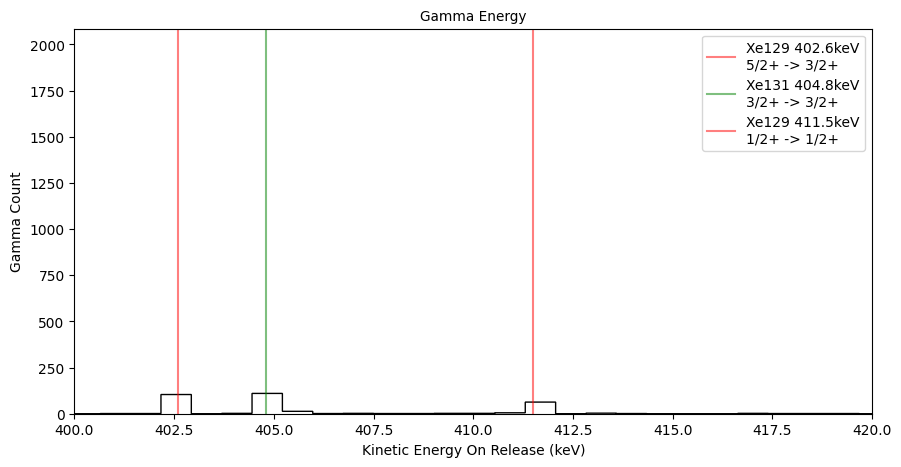

In [90]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(400, 420)
#plt.ylim(0, 30)

plt.axvline(402.6, color='red', alpha=0.5, label='Xe129 402.6keV' + '\n' + '5/2+ -> 3/2+') 
plt.axvline(404.814, color='green', alpha=0.5, label='Xe131 404.8keV'+ '\n' + '3/2+ -> 3/2+')
plt.axvline(411.490, color='red', alpha=0.5, label='Xe129 411.5keV' + '\n' + '1/2+ -> 1/2+') 

plt.legend()


In [91]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>400 and item<420]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec,2), return_counts=True)

In [92]:
print(energies)
print(counts)

[401.1  401.74 402.27 402.6  402.73 404.35 404.42 404.52 404.55 404.57
 404.58 404.59 404.61 404.62 404.64 404.65 404.66 404.67 404.68 404.69
 404.7  404.71 404.72 404.73 404.74 404.75 404.76 404.77 404.78 404.79
 404.8  404.81 405.36 405.45 405.6  406.13 407.4  407.83 408.7  409.49
 409.5  410.09 410.36 411.23 411.24 411.28 411.3  411.31 411.34 411.38
 411.39 411.4  411.41 411.42 411.43 411.45 411.46 411.47 411.48 411.49
 411.55 413.11 413.37 413.96 416.94 417.19 418.   418.28 419.35]
[  1   1   1 102   1   1   1   1   1   4   1   2   1   1   1   1   1   2
   1   3   2   4   3   3   3   4   4   2   3   4   4  54   1  11   1   1
   2   1   1   1   1   1   1   2   1   1   1   1   1   3   3   2   3   2
   1   2   4   2   2  35   2   1   2   1   1   1   1   1   1]


##### Looking at small peak 2160-2180keV

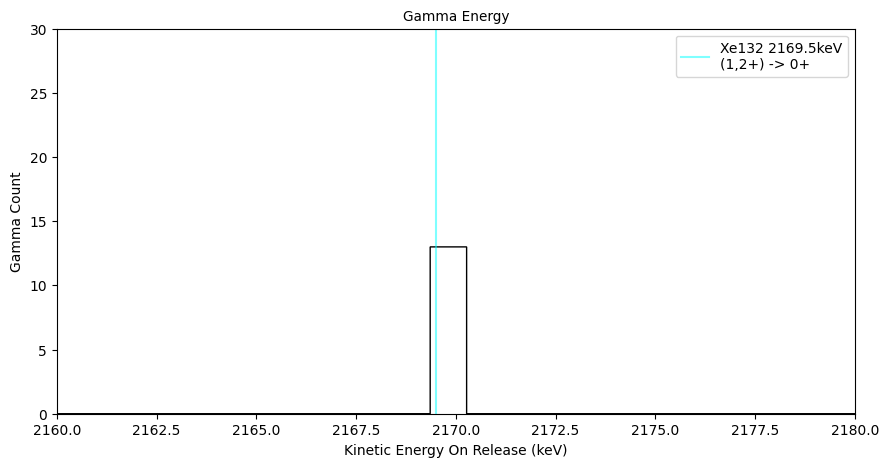

In [93]:

plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 2500, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(2160, 2180)
plt.ylim(0, 30)


plt.axvline(2169.5, color='cyan', alpha=0.5, label='Xe132 2169.5keV' + '\n' + '(1,2+) -> 0+')
plt.legend()


In [94]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>2160 and item<2180]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec,2), return_counts=True)

In [95]:
energies, counts

(array([2169.8]), array([13]))

##### 129m 

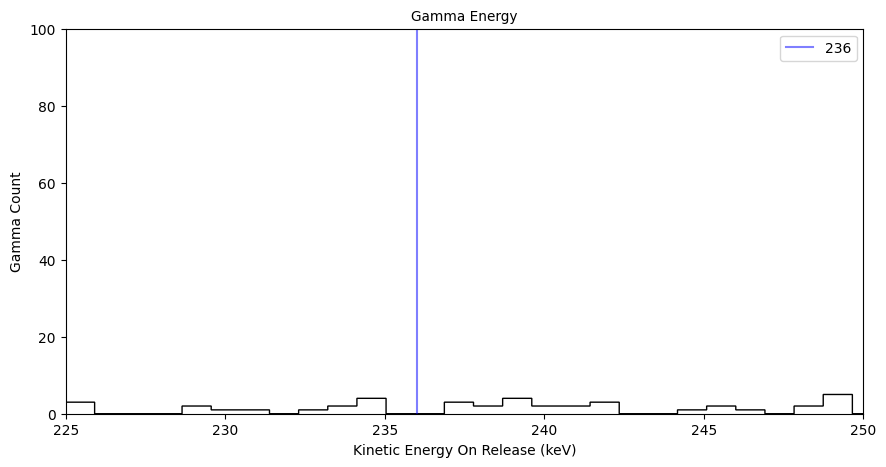

In [96]:
#129mXe 236keV
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 2500, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(225, 250)
plt.ylim(0, 100)




plt.axvline(236, color='blue', alpha=0.5, label='236')
plt.legend()


##### Looking at small peaks 280-300keV

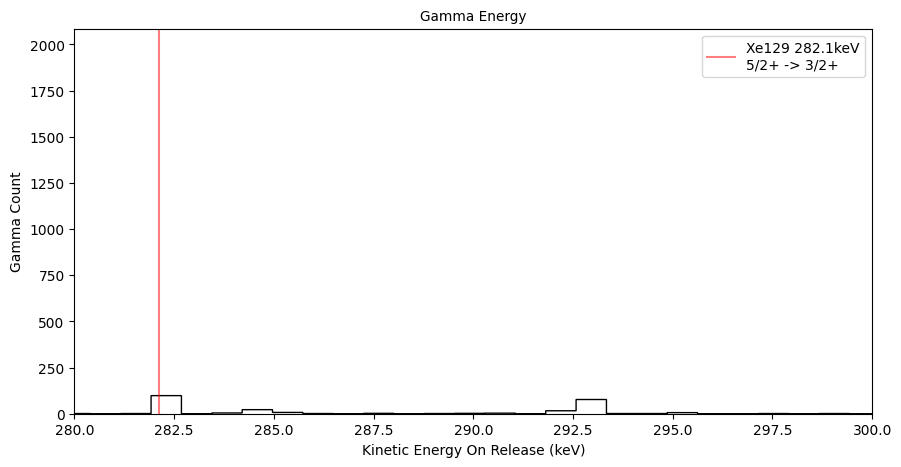

In [97]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(280, 300)
#plt.ylim(0, 50)

plt.axvline(282.131, color='red', alpha=0.5, label='Xe129 282.1keV' + '\n' + '5/2+ -> 3/2+') 

plt.legend()


In [98]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>280 and item<300]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec,2), return_counts=True)

In [99]:
energies, counts

(array([281.74, 282.05, 282.13, 283.46, 284.05, 284.1 , 284.2 , 284.21,
        284.23, 284.24, 284.26, 284.28, 284.29, 284.3 , 284.49, 285.21,
        285.34, 285.36, 285.55, 285.99, 287.52, 289.14, 290.25, 290.49,
        290.87, 292.39, 292.43, 292.45, 292.5 , 292.53, 292.54, 292.55,
        292.59, 292.6 , 292.61, 292.62, 292.64, 292.67, 292.68, 292.69,
        292.7 , 292.71, 292.74, 292.76, 292.78, 292.8 , 292.81, 292.83,
        292.84, 292.85, 292.88, 292.91, 292.97, 292.98, 293.89, 294.82,
        295.09, 297.46, 299.11]),
 array([ 1,  1, 97,  1,  1,  1,  1,  1,  1,  2,  1,  2,  1, 12,  2,  1,  1,
         3,  2,  1,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  4,  6,  2,
         4,  4,  4,  1,  6,  2,  6, 10,  2,  6,  2,  4,  2,  2,  2,  2,  2,
         2,  4,  2,  1,  1,  6,  1,  1]))

Can't find the 292 peak??

##### Xe124 Lowest Excitation Energy Peak

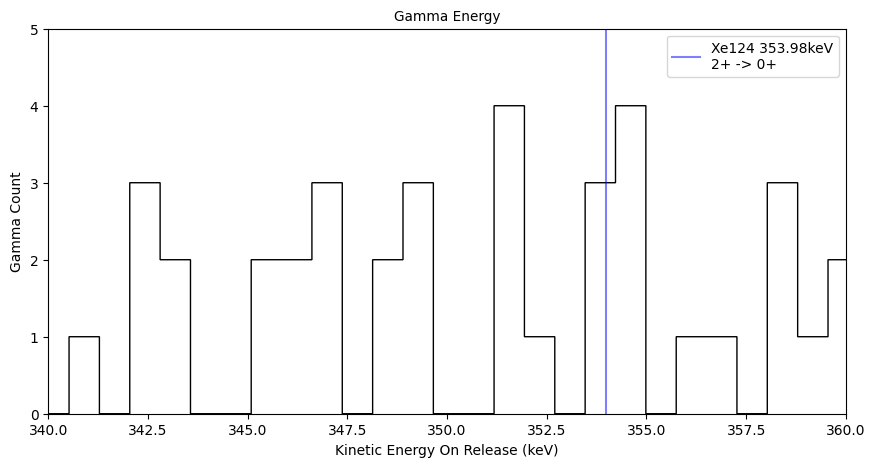

In [100]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(340, 360)
plt.ylim(0, 5)

plt.axvline(353.98, color='blue', alpha=0.5, label='Xe124 353.98keV'+ '\n' + '2+ -> 0+')
plt.legend()


##### Gammas <40keV

(0.0, 35.0)

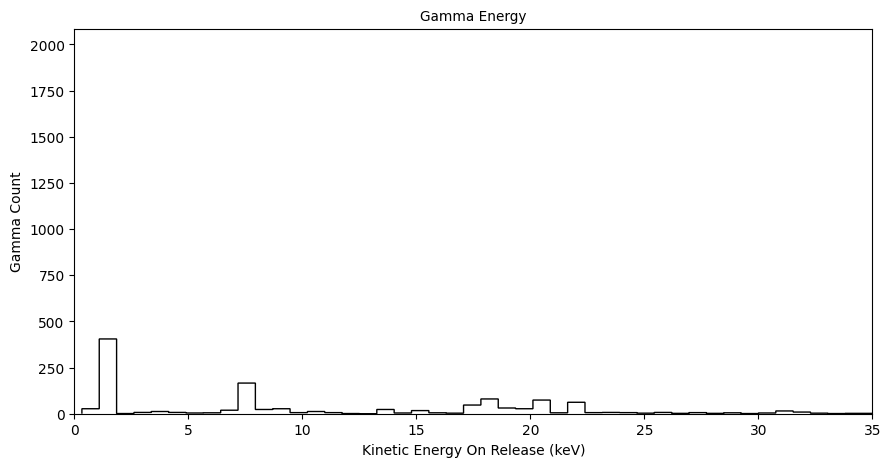

In [101]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(0, 35)
#plt.ylim(0, 75)


In [196]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item<35]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec), return_counts=True)

In [197]:
energies, counts

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35.]),
 array([  2, 243, 188,   8,  14,   6,   7,  41, 159,  36,  10,  12,   2,
          2,  23,  16,  10,   8, 112,  40,  97,   7,  64,   9,   9,   4,
          7,   5,   4,   6,   2,  13,  15,   2,   2,   1]))

Not sure cause of very low energy gammas -> these gammas may be from inelastic scatter of neutron outside xenon, therefore have time to lose energy before entering xenon 

Try and re-analyse to cut these out 

### Gamma Energies (only from primary scatters)

In [198]:
#find the kinetic energies of gammas released by de-excitation of xenon nuclei to compare to literature
primary_gammas_energy = []

for i_evt in primary_inelastic_events:
        
    gamma_energy = []
    for i_particle, particle in enumerate(events[i_evt]['track.particleNames']):
     
        if particle == 'gamma' and events[i_evt]['track.particleCreatorProcesses'][i_particle] == 'neutronInelastic' and events[i_evt]['track.particleParentIDs'][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            gamma_energy.append(events[i_evt]["track.step.kinEnergies_keV"][i_particle][0]) #energy at first step
            
    primary_gammas_energy.append(gamma_energy)


In [199]:
primary_gammas_energy = np.concatenate(primary_gammas_energy)

(0.0, 75.0)

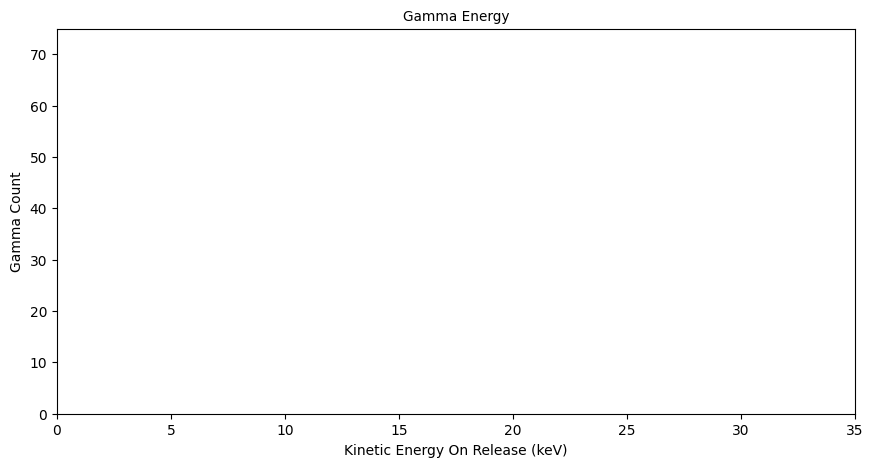

In [200]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(primary_gammas_energy, 3000, histtype='step', color='black') 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(0, 35)
plt.ylim(0, 75)

Much fewer low energy gammas then previous gamma energy plot

## Kinetic Energies of Gamma Rays Sorted By Isotope

In [113]:
#find the kinetic energies of gammas released by de-excitation of xenon nuclei to compare to literature
gammas_energies_xe124 = []
gammas_energies_xe126 = []
gammas_energies_xe128 = []
gammas_energies_xe129 = []
gammas_energies_xe130 = []
gammas_energies_xe131 = []
gammas_energies_xe132 = []
gammas_energies_xe134 = []
gammas_energies_xe136 = []

for x in range(len(event_names)):
    
    counter = 0
    for n in event_names[x]:
        if n.startswith('Xe'):
            counter+=1
          
    #only single inelastic scatters 
    if counter==1:
    
        if 'Xe124' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe124.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe126' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe126.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe128' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe128.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe129' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe129.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe130' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe130.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe131' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe131.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe132' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe132.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe134' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe134.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe136' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe136.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 



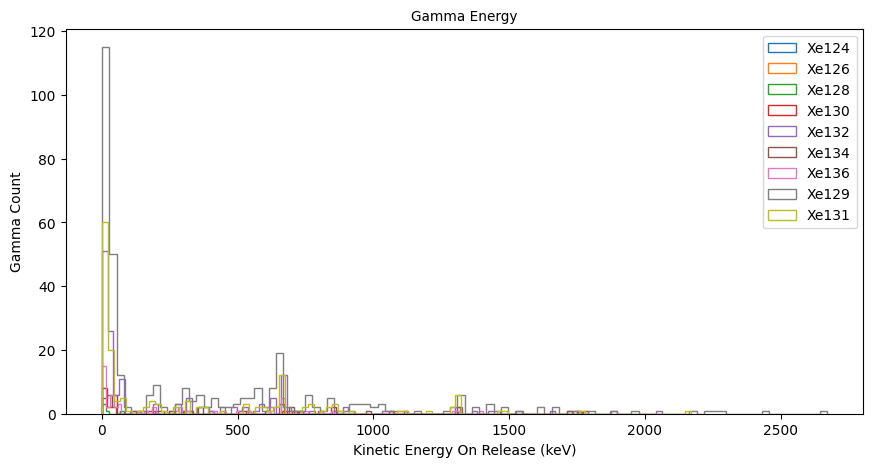

In [114]:
plt.figure(figsize=(35, 5));
plt.subplot(131);

plt.hist(gammas_energies_xe124, 100, histtype='step', label='Xe124')
plt.hist(gammas_energies_xe126, 100, histtype='step', label='Xe126')
plt.hist(gammas_energies_xe128, 100, histtype='step', label='Xe128')

plt.hist(gammas_energies_xe130, 100, histtype='step', label='Xe130')

plt.hist(gammas_energies_xe132, 100, histtype='step', label='Xe132')
plt.hist(gammas_energies_xe134, 100, histtype='step', label='Xe134')
plt.hist(gammas_energies_xe136, 100, histtype='step', label='Xe136')

plt.hist(gammas_energies_xe129, 100, histtype='step', label='Xe129')
plt.hist(gammas_energies_xe131, 100, histtype='step', label='Xe131')


plt.legend()
plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));




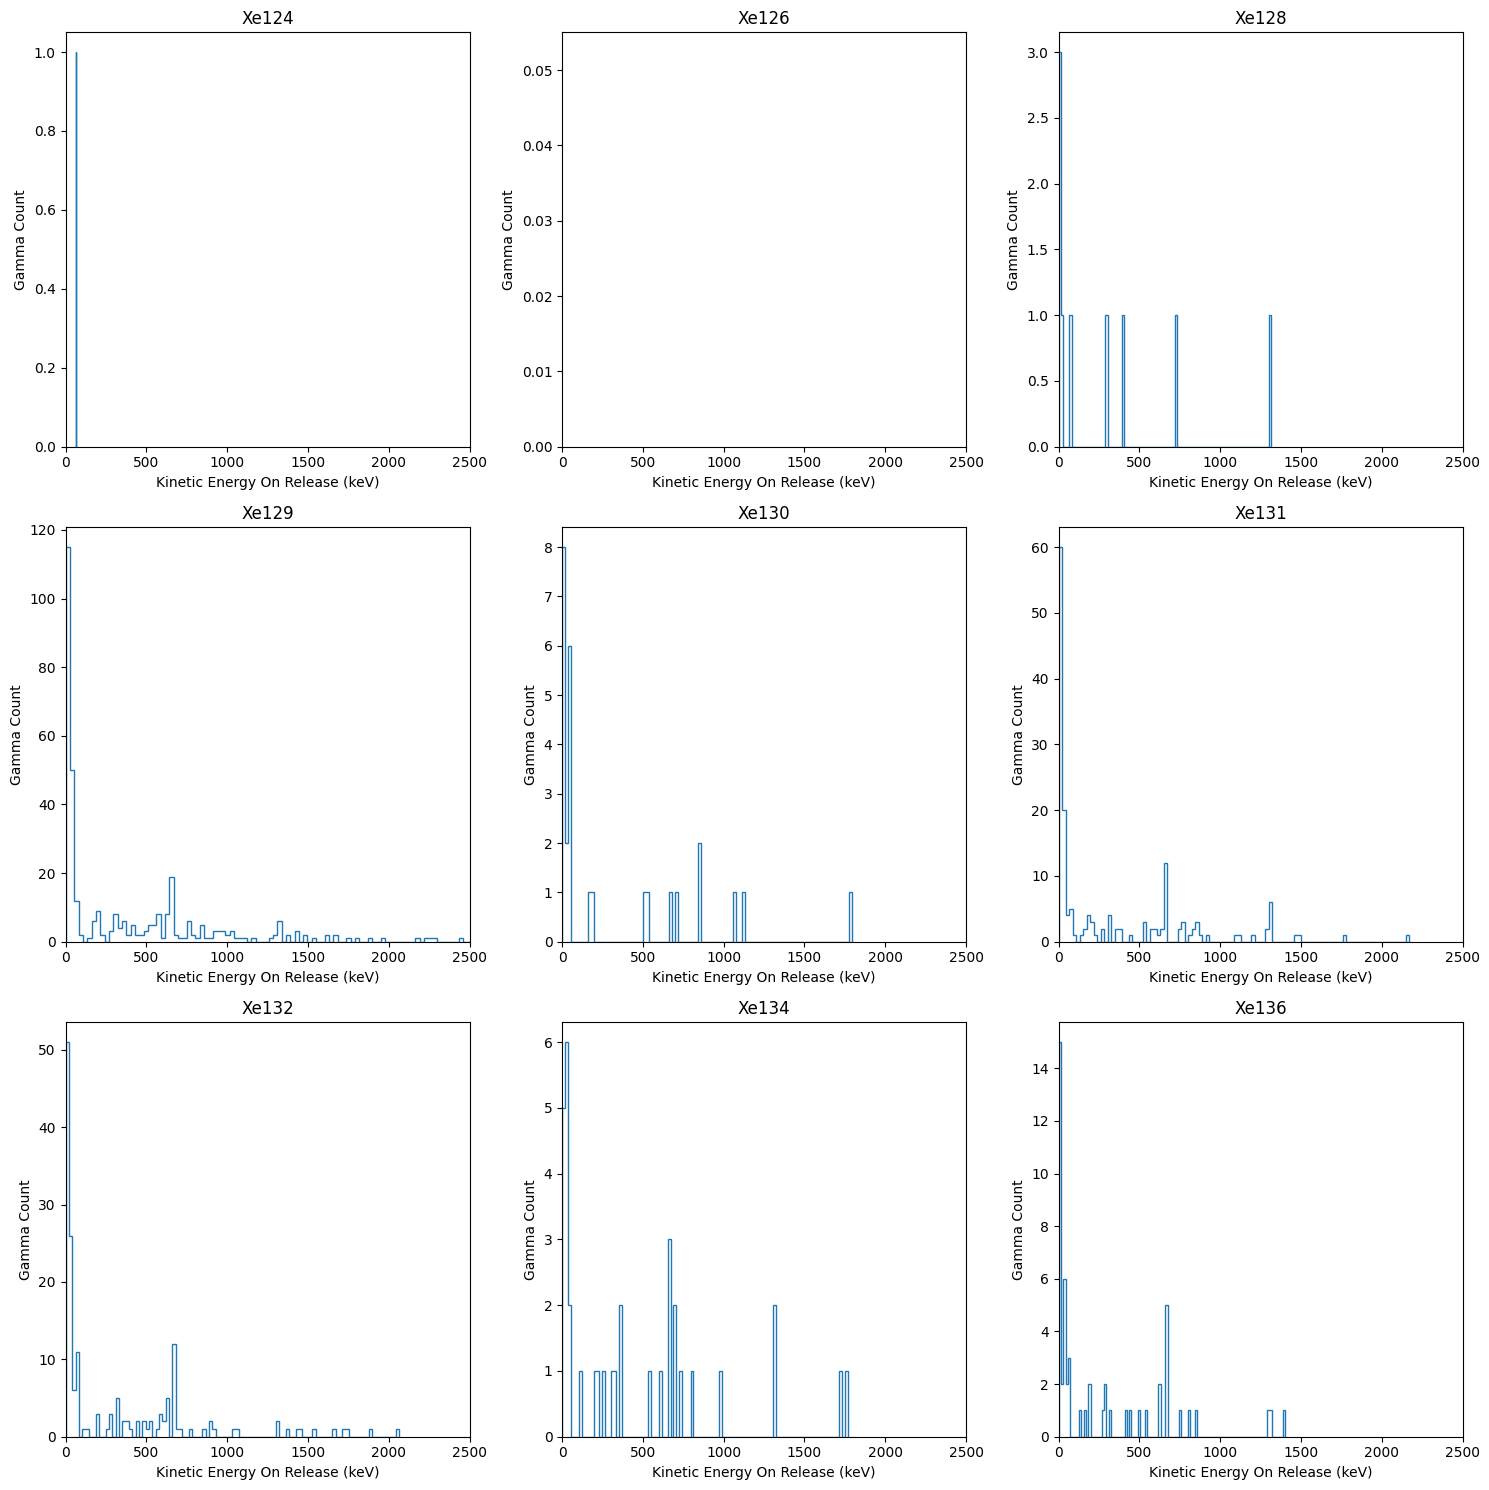

In [115]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms in each subplot
axes[0].hist(gammas_energies_xe124, 100, histtype='step')
axes[0].set_title('Xe124')
axes[1].hist(gammas_energies_xe126, 100, histtype='step')
axes[1].set_title('Xe126')
axes[2].hist(gammas_energies_xe128, 100, histtype='step')
axes[2].set_title('Xe128')
axes[3].hist(gammas_energies_xe129, 100, histtype='step')
axes[3].set_title('Xe129')
axes[4].hist(gammas_energies_xe130, 100, histtype='step')
axes[4].set_title('Xe130')
axes[5].hist(gammas_energies_xe131, 100, histtype='step')
axes[5].set_title('Xe131')
axes[6].hist(gammas_energies_xe132, 100, histtype='step')
axes[6].set_title('Xe132')
axes[7].hist(gammas_energies_xe134, 100, histtype='step')
axes[7].set_title('Xe134')
axes[8].hist(gammas_energies_xe136, 100, histtype='step')
axes[8].set_title('Xe136')

for i in range(9):
    axes[i].set_xlabel('Kinetic Energy On Release (keV)')  # Add x-axis label
    axes[i].set_ylabel('Gamma Count')  # Add y-axis label
    axes[i].set_xlim(0, 2500)  # Set x-axis limits
    axes[i].set_ylim(0,)  # Set y-axis limits
    
    
# Adjust the layout
plt.tight_layout()
plt.show()

#### checking low energies

(0.0, 35.0)

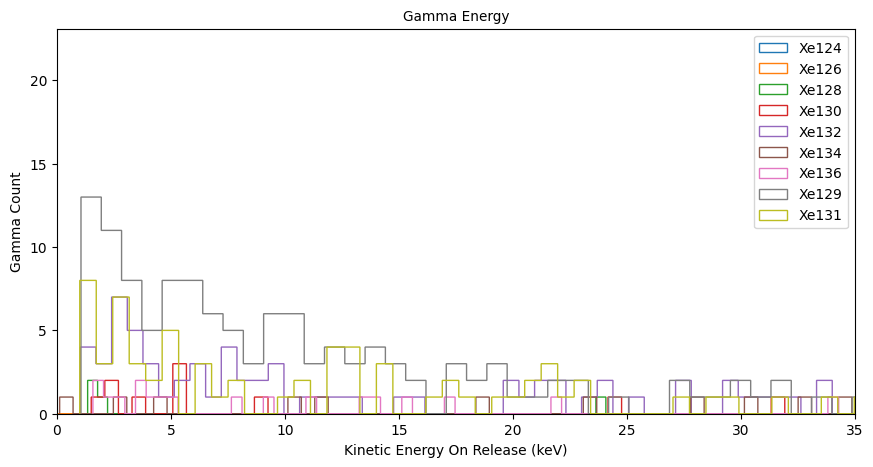

In [118]:
plt.figure(figsize=(35, 5));
plt.subplot(131);

plt.hist(gammas_energies_xe124, 3000, histtype='step', label='Xe124')
plt.hist(gammas_energies_xe126, 3000, histtype='step', label='Xe126')
plt.hist(gammas_energies_xe128, 3000, histtype='step', label='Xe128')

plt.hist(gammas_energies_xe130, 3000, histtype='step', label='Xe130')

plt.hist(gammas_energies_xe132, 3000, histtype='step', label='Xe132')
plt.hist(gammas_energies_xe134, 3000, histtype='step', label='Xe134')
plt.hist(gammas_energies_xe136, 3000, histtype='step', label='Xe136')

plt.hist(gammas_energies_xe129, 3000, histtype='step', label='Xe129')
plt.hist(gammas_energies_xe131, 3000, histtype='step', label='Xe131')


plt.legend()
plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.ylim(0,)
plt.xlim(0,35)


## Checking Peaks

Look at each isotope individually 

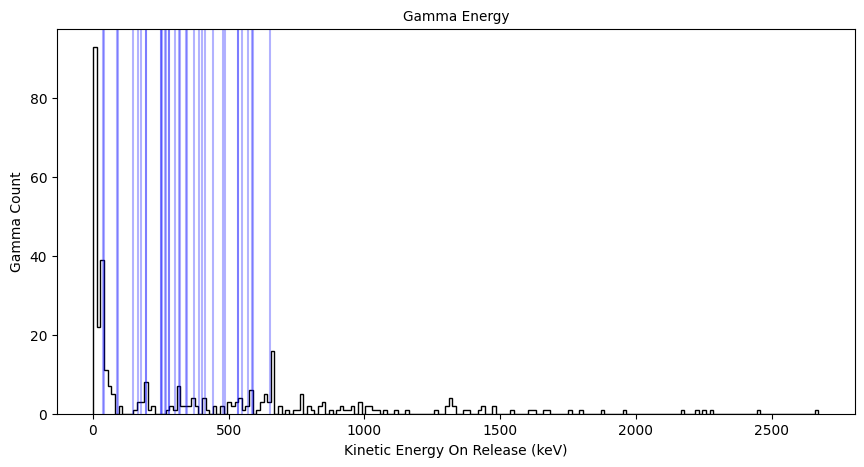

In [130]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energies_xe129, 200, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));

#do a csv read in 
gammas129 = [39.578,
196.56,
38.1,
278.614,
318.18,
282.131,
321.7,
89.79,
93.329,
371.918,
411.49,
402.6,
442.2,
196.9,
479.1,
485.7,
250.9,
254.5,
533.1,
572.73,
177.036,
266.82,
270.352,
548.945,
588.549,
302.6,
585,
146.8,
343.7,
347.3,
391.1,
167.7,
250.8,
653.4,
535.1]

for l in gammas129:
    plt.axvline(l, color='blue', alpha=0.3) 
    

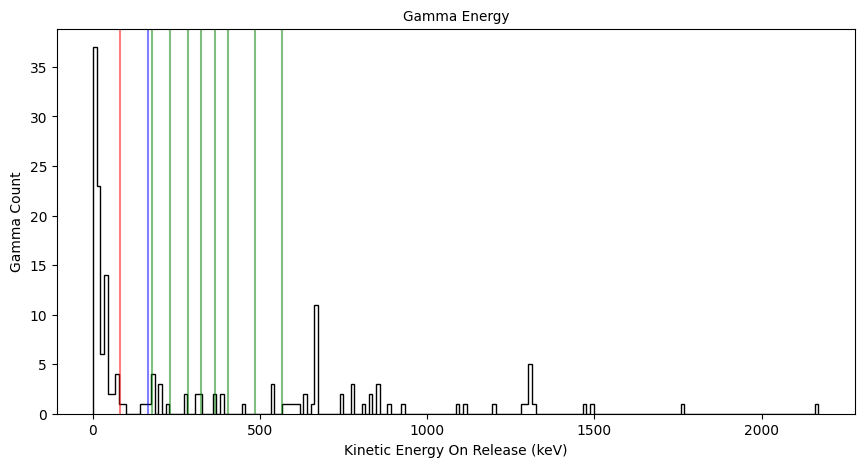

In [126]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energies_xe131, 200, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
#plt.xlim(0, 35)
#plt.ylim(0, 75)

plt.axvline(80.1854, color='red', alpha=0.5, label='Xe131') #lowest - anything lower is fake
plt.axvline(163.93, color='blue', alpha=0.5) #metastable
plt.axvline(177.21, color='green', alpha=0.5)
plt.axvline(284.305, color='green', alpha=0.5)
plt.axvline(364.489, color='green', alpha=0.5)
plt.axvline(324.651, color='green', alpha=0.5)
plt.axvline(404.814, color='green', alpha=0.5)
plt.axvline(485.0, color='green', alpha=0.5)
plt.axvline(565.2, color='green', alpha=0.5)
plt.axvline(232.18, color='green', alpha=0.5)




In [132]:
#read in literature xenon data

# Directory containing the CSV files
directory = '/global/cfs/projectdirs/lz/users/amcadam/xenon_data'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Store the DataFrame in the dictionary
        dfs[filename] = df

# Access a specific DataFrame
print(dfs['xe129.csv'].keys())

# get gammas energies
print(np.round(dfs['xe129.csv'][' energy [keV]'][:10]))

Index(['Z', 'N', 'symbol', 'start level #', 'start level energy [keV]', ' unc',
       ' start level jp', 'final level #', 'final level energy [keV]',
       ' unc.1', 'final level jp', ' idx', ' energy [keV]', ' unc.2',
       ' relative intensity ', ' unc.3', ' multipolarity', ' mixing ratio',
       ' unc.4', ' B(E1)', ' B(E1) unc', ' B(E2)', ' B(E2) unc', ' B(M1)',
       ' B(M1) unc', ' B(M2)', ' B(M2) unc', 'tot conv coeff', 'unc',
       'ENSDF_publication_cut-off', 'ENSDF_authors', 'Extraction_date'],
      dtype='object')
0     40.0
1    197.0
2     38.0
3    279.0
4    318.0
5    282.0
6    322.0
7     90.0
8     93.0
9    372.0
Name:  energy [keV], dtype: float64


In [134]:
#look at all isotopes to get lists or real and fake lines for each one 
#loop through dataframes 
gamma_data = {}

for key in list(dfs.keys()):
    lit_data_gammas = dfs[key][' energy [keV]']
    sim_data_gammas_name = f"gammas_energies_{key[:5]}"
    sim_data_gammas = globals().get(sim_data_gammas_name)
    
    sim_lines, counts = np.unique(np.round(sim_data_gammas), return_counts=True)
    
    #round energies whole number and compare sim to literature
    real = []
    fake = []
    for line in list(sim_lines):
        if line in list(np.round(lit_data_gammas)):
            real.append(line)
        else:
            fake.append(line)

    missing = []
    for line in list(np.round(lit_data_gammas)):
        if line not in list(sim_lines) and line<2450:
            missing.append(line)
                        
    data = {'real': real, 'fake': fake, 'missing': missing}
        
    gamma_data[key[:5]] = data #dictionary of dictionaries 
    

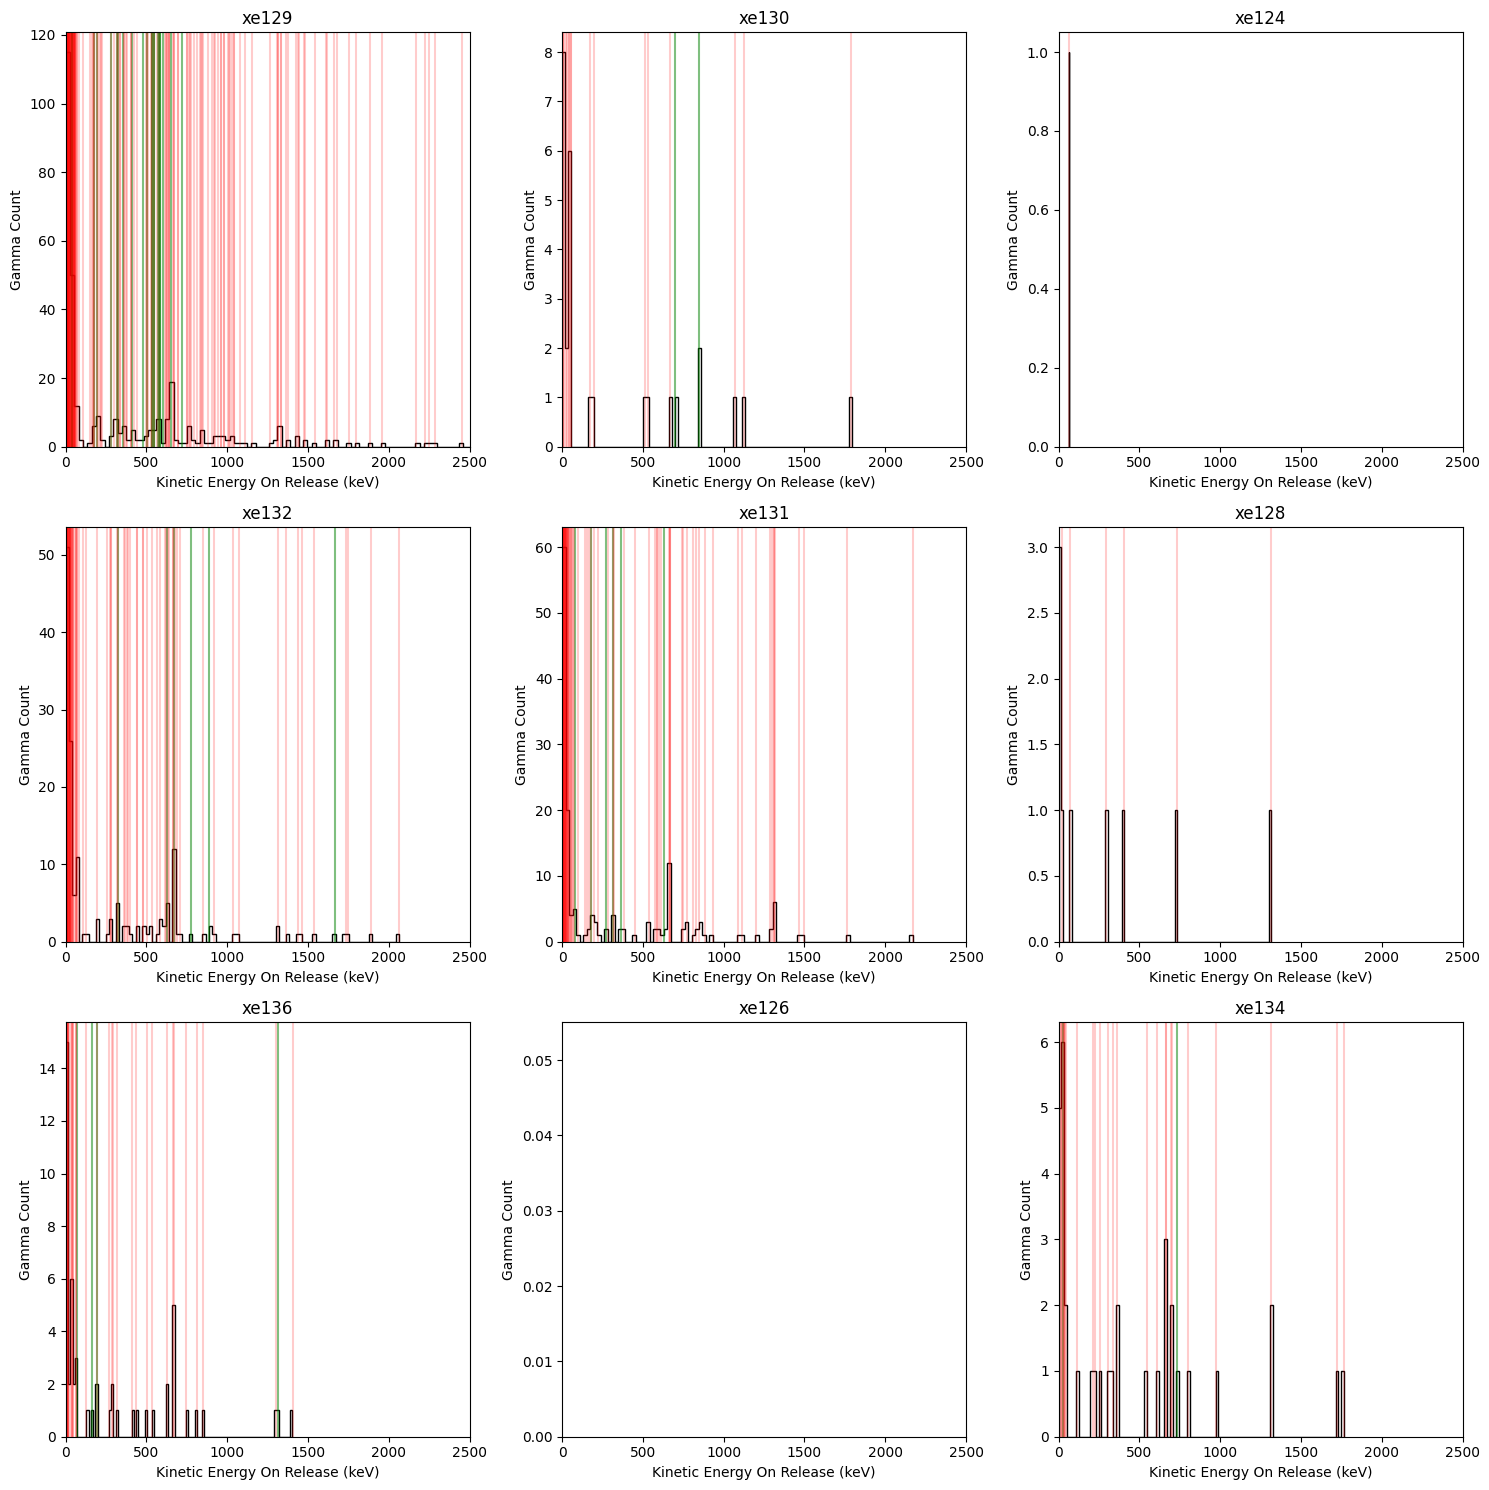

In [135]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()


for i, key in enumerate(list(gamma_data.keys())):
    
    sim_data_gammas_name = f"gammas_energies_{key}"
    sim_data_gammas = globals().get(sim_data_gammas_name)
  
    # Plot histograms in each subplot
    axes[i].hist(sim_data_gammas, 100, histtype='step', color='black')
    axes[i].set_title(key)
    
    #Plot lines in each subplot 
    for line in gamma_data[key]['real']:
        axes[i].axvline(line, color='green', alpha=0.5) 
        
    #for line in gamma_data[key]['missing']:
    #    axes[i].axvline(line, color='blue', alpha=0.1) 
    
    for line in gamma_data[key]['fake']:
        axes[i].axvline(line, color='red', alpha=0.2) 
    
    axes[i].set_xlim(0, 2500)  # Set x-axis limits
    axes[i].set_ylim(0,)  # Set y-axis limits
    
    axes[i].set_xlabel('Kinetic Energy On Release (keV)')  # Add x-axis label
    axes[i].set_ylabel('Gamma Count')  # Add y-axis label

    
    
# Adjust the layout
plt.tight_layout()
plt.show()

More fake lines possible from gamma energy decreasing as gammas may be produced outside tpc 

## Cross Section Comparison 

Compare ratio of neutron inelastic scatters, elastic scatters and capture to cross section prediction for 2.45MeV neutrons 

Only look at first step of primary neutron

Use neutrons in energy range 2.4-2.5MeV with cross-section data 2.45MeV

In [212]:
#looking at first step 

c1_primary_inelastic_events = [] 
c1_primary_elastic_events = [] 
c1_primary_ncapture_events = [] 
n = 0

elastic_scatter_id = find_processes('hadElastic')
ncapture_id = find_processes('nCapture')

for ii, i_evt in enumerate(events['header.eventId']):
    
    if (len(events[i_evt]['track.particleNames'])==0): #avoid empty events (doesn't reach xenon)
        continue
        
    if events[i_evt]['track.particleCreatorProcesses'][0] == 'primary' and events[i_evt]['track.step.kinEnergies_keV'][0][0] > 2400 and events[i_evt]['track.step.kinEnergies_keV'][0][0] < 2500:
        n+=1
        
        if events[i_evt]['track.step.processesID'][0][0] == neutronInelasticId: 
                c1_primary_inelastic_events.append(i_evt)

        if events[i_evt]['track.step.processesID'][0][0] == elastic_scatter_id:
                c1_primary_elastic_events.append(i_evt)

        if events[i_evt]['track.step.processesID'][0][0] == ncapture_id:
                c1_primary_ncapture_events.append(i_evt)
 

In [213]:
print(f'There are {n} primary neutrons in energy range 2.4-2.5MeV entering xenon')
print('In the first step:')
print(f'Inelastic scatters {len(c1_primary_inelastic_events)}')
print(f'Elastic scatters {len(c1_primary_elastic_events)}')
print(f'Neutron captures {len(c1_primary_ncapture_events)}')


There are 2954 primary neutrons in energy range 2.4-2.5MeV entering xenon
In the first step:
Inelastic scatters 898
Elastic scatters 1959
Neutron captures 7


In [214]:
#look at which Xenon isotopes captured neutrons 

particles = []
for i_evt in c1_primary_ncapture_events:
    particles.append(np.array(events[i_evt]['track.particleNames'][events[i_evt]['track.particleCreatorProcesses'] == 'nCapture']))

isotopes = []
for particle_array in particles:
    for p in particle_array:
        if p.startswith('Xe'):
            isotopes.append(p)
            
isotopes, counts = np.unique(np.array(isotopes), return_counts=True)

print('Neutrons were captured to form these Xenon isotopes:')
for i in range(len(isotopes)):
    print(f'{isotopes[i]} {counts[i]} occurances') 

print()
print(f'Xenon atoms counted: {np.sum(counts)}') 

Neutrons were captured to form these Xenon isotopes:
Xe130 2 occurances
Xe131 2 occurances
Xe132 2 occurances
Xe133 1 occurances

Xenon atoms counted: 7


In [215]:
#xenon data 
xe_isotopes = ['Xe124','Xe126', 'Xe128','Xe129','Xe130','Xe131','Xe132','Xe134','Xe136']
abundances = [0.09,0.09,1.92,26.44,4.08,21.18,26.89,10.44,8.87]

#cross sections each process for 2.45MeV neutrons
#from reading off ENDF interpolated plot estimation 

#elastic, inelastic, capture #unit barns 
xe124_cs = [3.11, 2.30, 0.129]
xe126_cs = [4.13, 1.34, 0.363]
xe128_cs = [4.16, 1.52, 0.105]
xe129_cs = [3.59, 1.87, 0.02]
xe130_cs = [3.55, 1.91, 0.0334]
xe131_cs = [3.79, 1.97, 0.012]
xe132_cs = [3.74, 1.74, 0.0089]
xe134_cs = [3.94, 1.66, 0.006]
xe136_cs = [4.20, 1.37, 0.00043]

cs = np.array([xe124_cs, xe126_cs, xe128_cs, xe129_cs, xe130_cs, xe131_cs, xe132_cs, xe134_cs, xe136_cs])


In [216]:
#weighted individual cross-sections
w = np.transpose(np.array([abundances]*3))

w_cs = w  * cs 
w_cs_nat_xenon = np.sum(w_cs, axis=0) 

In [217]:
w_cs_nat_xenon

array([377.2708   , 178.4771   ,   1.4708871])

In [218]:

print('Weighted Xenon Cross Section Ratios')
ratio = w_cs_nat_xenon/np.sum(w_cs_nat_xenon) 

print(f'Elastic: {ratio[0]}')
print(f'Inelastic: {ratio[1]}')
print(f'Capture: {ratio[2]}')

print('')

#ratio 
total = len(c1_primary_inelastic_events) + len(c1_primary_elastic_events) + len(c1_primary_ncapture_events)

print('Ratio of Each Process for Primary Neutron From Sim')
print(f'Elastic: {len(c1_primary_elastic_events)/total}')
print(f'Inelastic: {len(c1_primary_inelastic_events)/total}')
print(f'Capture: {len(c1_primary_ncapture_events)/total}')


Weighted Xenon Cross Section Ratios
Elastic: 0.6770604450784498
Inelastic: 0.32029986090180046
Capture: 0.002639694019749608

Ratio of Each Process for Primary Neutron From Sim
Elastic: 0.6840083798882681
Inelastic: 0.31354748603351956
Capture: 0.0024441340782122905


## Neutron Energies

Looking at data without energy cut -> For an any event with a neutron capture it appears that the neutron energy is generally a lot lower then 2.45MeV, this makes sense as cross section is higher for lower energies. How does the primary lose so much energy before entering xenon?

In [219]:
#plot neutron energies where there is no inelastic scatter before entering xenon and only neutron with primary creator 

neutron_energies = []
m = 0

for ii, i_evt in enumerate(events['header.eventId']):
    
    if events[i_evt]['volume.names'].tolist() != []:
        if events[i_evt]['track.particleCreatorProcesses'][0] == 'primary': #primary is always the neutron
            m+=1
            neutron_energies.append(events[i_evt]['track.step.kinEnergies_keV'][0][0])


In [220]:
print(f'There are {m} primary neutrons which reach xenon') #not sure if correct number, different to num_neutrons_xenon

There are 4890 primary neutrons which reach xenon


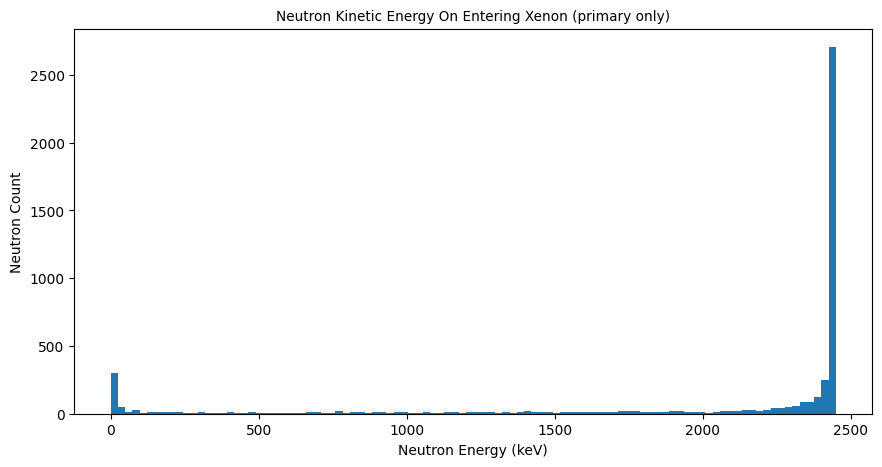

In [221]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(neutron_energies, 100) 
#plt.xlim(2350, 2500)

plt.xlabel('Neutron Energy (keV)')
plt.ylabel('Neutron Count')
plt.title('Neutron Kinetic Energy On Entering Xenon (primary only)', fontsize=(9.8));

Energies are all below 2.45MeV. There are still a few low energy neutrons, how do these lose so much energy?


## Inelastic Scatter Xenon De-excitation Gamma Emission Time

In [201]:
#get time of inelastic scatter - just look at primary neutron first inelastic scatters 

event_inelastic_times = [] 
primary_inelastic_events = [] 

for ii, i_evt in enumerate(events['header.eventId']):
    
    if (len(events[i_evt]['track.particleNames'])==0): #avoid empty events (doesn't reach xenon)
        continue
    
    #only looking at first inelastic scatters of primary neutron 
    if events[i_evt]['track.step.processesID'][0][-1] == neutronInelasticId and events[i_evt]['track.particleCreatorProcesses'][0] == 'primary': 
        inelastic_time = events[i_evt]['track.step.times_ns'][0][-1]
        event_inelastic_times.append(inelastic_time)
        primary_inelastic_events.append(i_evt)
        


In [202]:
#get time of gamma emission 
event_gamma_times = [] #array of arrays, multiple gammas from single scatter 

for i_evt in primary_inelastic_events:
        
    gamma_times = []
    for i_particle, particle in enumerate(events[i_evt]['track.particleNames']):
     
        if particle == 'gamma' and events[i_evt]['track.particleCreatorProcesses'][i_particle] == 'neutronInelastic' and events[i_evt]['track.particleParentIDs'][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            gamma_times.append(events[i_evt]['track.step.times_ns'][i_particle][0]) #time at first step
            
    event_gamma_times.append(gamma_times)

    

In [203]:
#get lifetime of excited state 
emission_times = [] #gamma emission times for each event in ns 
for i, event in enumerate(event_gamma_times):
    emission_time = np.array(event) - event_inelastic_times[i]
    emission_times.append(emission_time)

In [204]:
all_times = np.concatenate(emission_times)

In [205]:
len(all_times)

8098

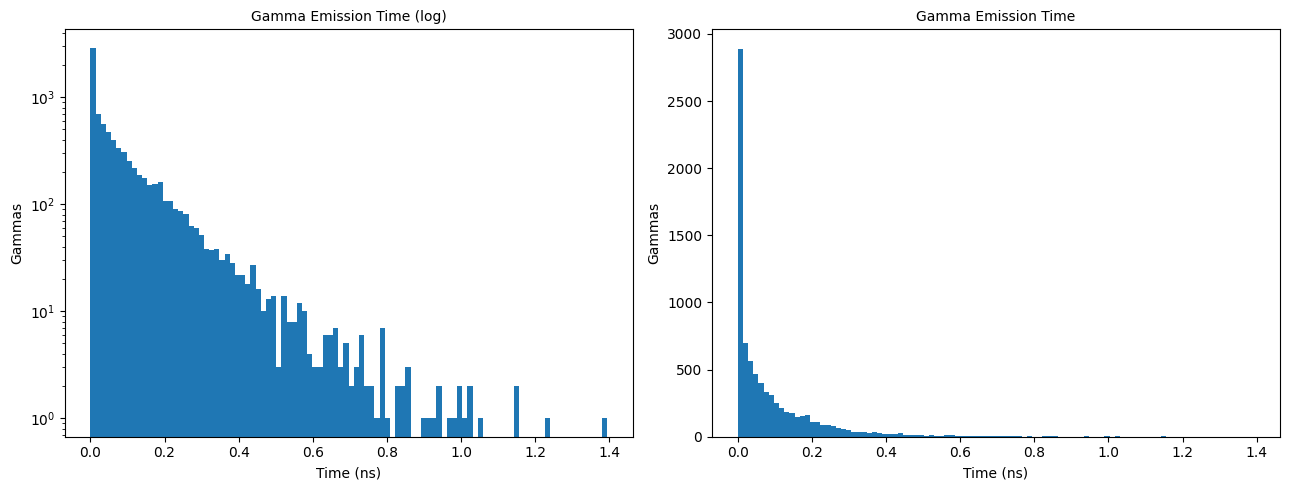

In [206]:
plt.figure(figsize=(13, 5));
plt.subplot(121);
plt.hist(all_times, 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('Gamma Emission Time (log)', fontsize=10);
plt.yscale('log');

plt.subplot(122);
plt.hist(all_times, 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('Gamma Emission Time', fontsize=10);

plt.tight_layout();

Large number of short times - should definitely be some longer ones I think but there are lots in picoseconds

Maybe useful to try and sort by isotope from sim or just by event?

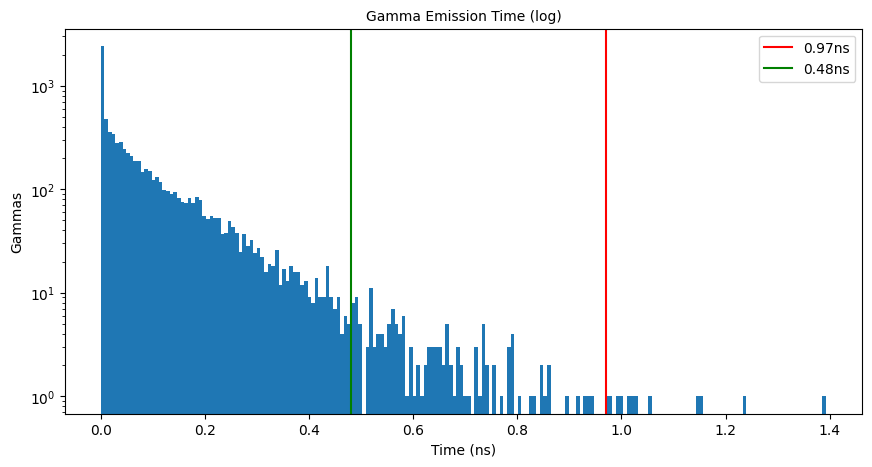

In [207]:
#look for most common transitions with known lifetimes 

plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(all_times, 200);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('Gamma Emission Time (log)', fontsize=10); 
plt.yscale('log');


#Xe129 39.58keV 0.97ns 
plt.axvline(0.97, color='red', label='0.97ns') 

#Xe131 80.185keV 0.48ns
plt.axvline(0.48, color='green', label='0.48ns')
plt.legend()


Potentially timing of gammas emissions may be wrong, seems to be lacking any long lived states

Try to do specific energy gammas to check timings

#### 40keV Gammas

In [46]:
#get times of 40keV gamma emission 
event_gamma_times = [] #array of arrays, multiple gammas from single scatter 

for i_evt in primary_inelastic_events:
        
    gamma_times = []
    for i_particle, particle in enumerate(events[i_evt]['track.particleNames']):
     
        if particle == 'gamma' and events[i_evt]['track.particleCreatorProcesses'][i_particle] == 'neutronInelastic' and events[i_evt]['track.particleParentIDs'][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            if events[i_evt]['track.step.kinEnergies_keV'][i_particle][0]>37 and events[i_evt]['track.step.kinEnergies_keV'][i_particle][0]<42:
                gamma_times.append(events[i_evt]['track.step.times_ns'][i_particle][0]) #time at first step
            
    event_gamma_times.append(gamma_times)


In [47]:
#get lifetime of excited state 
emission_times = [] #gamma emission times for each event in ns 
for i, event in enumerate(event_gamma_times):
    emission_time = np.array(event) - event_inelastic_times[i]
    emission_times.append(emission_time)

In [48]:
len(np.concatenate(emission_times)) #should there be more gammas than this?

180

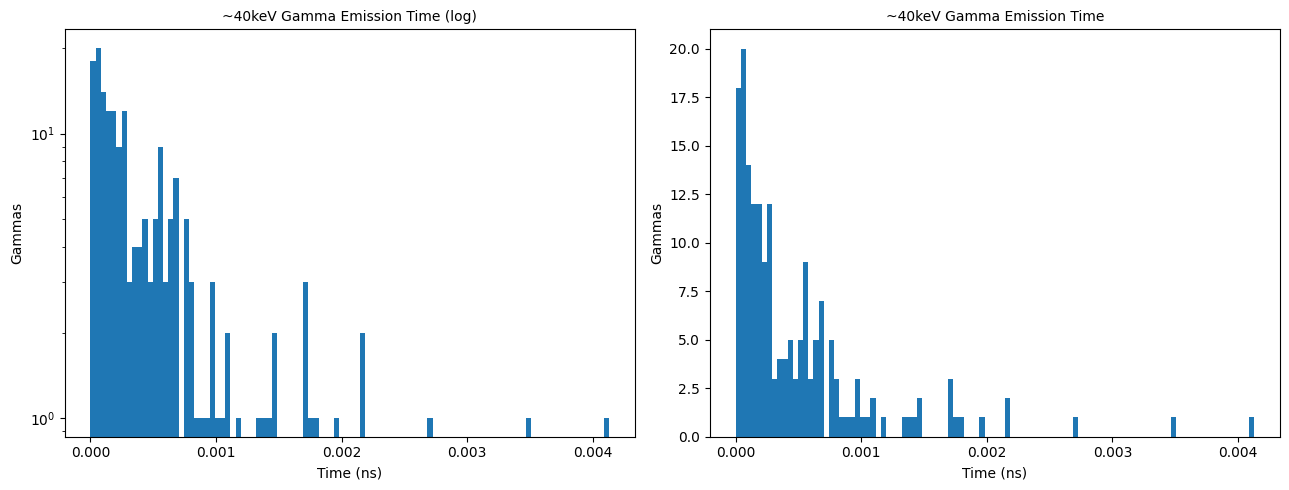

In [49]:
plt.figure(figsize=(13, 5));
plt.subplot(121);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('~40keV Gamma Emission Time (log)', fontsize=10);
plt.yscale('log');

plt.subplot(122);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('~40keV Gamma Emission Time', fontsize=10);

plt.tight_layout();

Lifetime of Xe129 40keV state is 0.97ns 

#### Long-lived 11.9d state of Xe131 163.93keV

In [165]:
#get times of 164keV gammas 
event_gamma_times = [] #array of arrays, multiple gammas from single scatter 

for i_evt in primary_inelastic_events:
        
    gamma_times = []
    for i_particle, particle in enumerate(events[i_evt]['track.particleNames']):
     
        if particle == 'gamma' and events[i_evt]['track.particleCreatorProcesses'][i_particle] == 'neutronInelastic' and events[i_evt]['track.particleParentIDs'][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            if events[i_evt]['track.step.kinEnergies_keV'][i_particle][0]>163 and events[i_evt]['track.step.kinEnergies_keV'][i_particle][0]<164:
                gamma_times.append(events[i_evt]['track.step.times_ns'][i_particle][0]) #time at first step
            
    event_gamma_times.append(gamma_times)


In [166]:
#get lifetime of excited state 
emission_times = [] #gamma emission times for each event in ns 
for i, event in enumerate(event_gamma_times):
    emission_time = np.array(event) - event_inelastic_times[i]
    emission_times.append(emission_time)

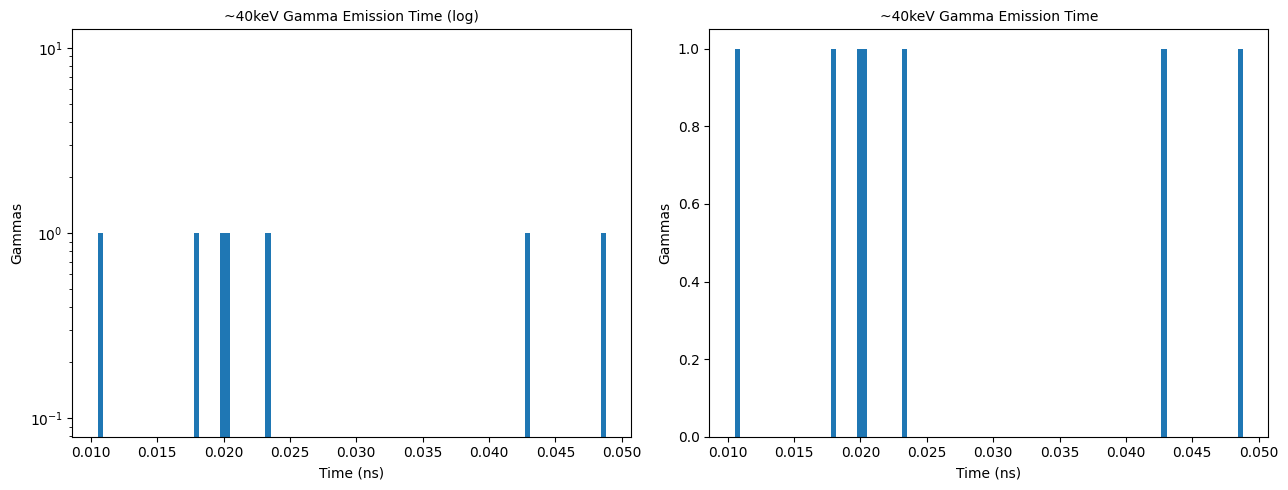

In [167]:
plt.figure(figsize=(13, 5));
plt.subplot(121);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('~164keV Gamma Emission Time (log)', fontsize=10);
plt.yscale('log');

plt.subplot(122);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('~164keV Gamma Emission Time', fontsize=10);

plt.tight_layout();

## Single/Multiple Scatters LZLAMA

Ran LZLAMA on energy only sims 

Difference in results if using xenon or all volumes -> makes sense, not sure which to use -> probably only want events in xenon?

In [16]:
#file_lzlama = '/global/cfs/projectdirs/lz/users/amcadam/lz_DD_root_135458397_LZLAMA_SR1_lzap.root'  #10000
#file_lzlama = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_root_35547824_LZLAMA_SR1_lzap.root' #20000
file_lzlama = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_root_75620945_LZLAMA_SR1_lzap.root' #100000


In [17]:
content = uproot.open(file_lzlama)
print(f'Trees inside file: {content.keys()}')

Trees inside file: ['Events;1', 'Scatters;1', 'RQMCTruth;1']


In [18]:
events_lzlama = content["Events"].arrays() 
scatters = content["Scatters"].arrays()  
rqmctruth = content["RQMCTruth"].arrays() 

In [19]:
n_ss, counts_ss = np.unique(scatters["ss.nSingleScatters"], return_counts=True)

In [20]:
print(f'Total number of events with single scatters: {counts_ss[1]}')

Total number of events with single scatters: 861


In [21]:
n_ms, counts_ms = np.unique(scatters["ms.nMultipleScatters"], return_counts=True)

In [22]:
print(f'Total number of events with multiple scatters: {counts_ms[1]}')

Total number of events with multiple scatters: 3907


#### All volumes sim

In [40]:
file_allvolumes = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_allvolumes_root_35547824.root' #20000
#file_lzlama = '/global/cfs/projectdirs/lz/users/amcadam/baccarat/simsDD/lz_DD_allvolumes_root_35547824_LZLAMA_SR1_lzap.root' #20000 all volumes 


### Inelastic Events

Find percentage of inelastic scatters that are single and multiple 

In [70]:
inelastic_events_lzlama = []
inelastic_events_ss = []
inelastic_events_ms = []

for evta in inelastic_events:
    for i, evtb in enumerate(events_lzlama["eventHeader.eventID"]):
        if evta==evtb:
            inelastic_events_lzlama.append(i)
            if scatters[i]["ss.nSingleScatters"] == 1:
                inelastic_events_ss.append(evta)
            elif scatters[i]["ms.nMultipleScatters"] == 1:
                inelastic_events_ms.append(evta)
            
inelastic_ss = len(inelastic_events_ss)
inelastic_ms = len(inelastic_events_ms)

In [71]:
total = inelastic_ss+inelastic_ms

print('Percentage inelastic events')
print(f'Single scatter: {round(100*inelastic_ss/total, 2)}%')
print(f'Multiple scatter: {round(100*inelastic_ms/total, 2)}%')


Percentage inelastic events
Single scatter: 2.43%
Multiple scatter: 97.57%


## Clustering 

In [72]:
#parameters
zres = 10 #mm -> distance between cluster members will be lower
xres = 30 #mm
yres = 30 #mm
energy_threshold = 5 #keV -> sum total energy of cluster if below undetectable 
timescale = 7 #µs -> time between cluster members will be lower 

In [73]:
def cluster_func(data): #data for 1 event 

    cluster = [] #holds cluster so can remove later 
    cluster_index = []
    unclustered_index = []

    #find max deposit 
    max_deposit = data['energyDep_keV'][0]
    max_i = 0

    for i_dep, dep in enumerate(data['energyDep_keV']):
        if dep>max_deposit:
            max_deposit=dep
            max_i = i_dep 

    max_time = data['time_ns'][max_i]
    max_x = data['positionX_mm'][max_i]
    max_y = data['positionY_mm'][max_i]
    max_z = data['positionZ_mm'][max_i]

    cluster.append(max_deposit)
    cluster_index.append(max_i)
    

    #loop through each deposit to get cluster 
    for i_dep, dep in enumerate(data['energyDep_keV']):

    
        #not max 
        if not dep == max_deposit:

            #check euclidean distance -> only zres? or use x and y?
            x = abs(data['positionX_mm'][i_dep] - max_x)
            y = abs(data['positionY_mm'][i_dep] - max_y)
            z = abs(data['positionZ_mm'][i_dep] - max_z)
                    
            #check timescale 
            time_diff = abs(max_time-data['time_ns'][i_dep]) #max deposit not nessarily first 
            t = timescale*(0.01) #need to change to ns 
            
            #if  z<zres and time_diff<t:
            if z<zres and x<xres and y<yres and time_diff<t: #adding x and y 
                cluster.append(dep)
                cluster_index.append(i_dep)
                
            else: 
                unclustered_index.append(i_dep)
  
                    
                    
    return cluster, cluster_index, unclustered_index

    

In [74]:
#clustering 
events_clusters = {} 
events_clusters['eventID'] = events['header.eventId']
events_clusters_list = [] #list of lists for each event 
events_clusters_list_eth = [] #hold those above energy threshold 

#loop through events 
for i, evt in enumerate(events['header.eventId']):
    
    clusters = []
    clusters_eth = []
    
    #set up event data 
    event_data = {}
    event_data['eventID'] = events['header.eventId'][i]
    event_data['energyDep_keV'] = events['deposits.EnergyDeps_keV'][i]
    event_data['time_ns'] = events['deposits.times_ns'][i]
    event_data['positionX_mm'] = events['deposits.positions_x_mm'][i]
    event_data['positionY_mm'] = events['deposits.positions_y_mm'][i]
    event_data['positionZ_mm'] = events['deposits.positions_z_mm'][i]

    
    #loop over data until all clustered 
    empty=False
    while empty==False:
    
        #cluster 
        cluster, index, unclustered = cluster_func(event_data)
        clusters.append(cluster)
        
        #energy threshold check
        if np.sum(np.array(cluster)) > energy_threshold:
            clusters_eth.append(cluster)
        
        #remove if any deposits left 
        
        #unclustered index 
        event_data_update = {}
        event_data_update['energyDep_keV'] = event_data['energyDep_keV'][unclustered]
        event_data_update['time_ns'] = event_data['time_ns'][unclustered]
        event_data_update['positionX_mm'] = event_data['positionX_mm'][unclustered] 
        event_data_update['positionY_mm'] = event_data['positionY_mm'][unclustered] 
        event_data_update['positionZ_mm'] = event_data['positionZ_mm'][unclustered]       

        event_data=event_data_update

        if event_data['energyDep_keV'].tolist() == []:
            empty=True 
         
    events_clusters_list.append(clusters)
    events_clusters_list_eth.append(clusters_eth)
     
    

    
events_clusters['depositClusters_keV'] = events_clusters_list
events_clusters['depositClustersThreshold_keV'] = events_clusters_list_eth


IndexError: cannot slice NumpyArray (of length 0) with 0: index 0 is out of bounds for axis 0 with size 0

This error occurred while attempting to slice

    <Array [] type='0 * float64'>

with

    0

In [75]:
#count clusters to get single/multiple scatter ratio 
ss = 0
ms = 0
none = 0
for clusters in events_clusters['depositClustersThreshold_keV']:
    if len(clusters) == 1:
        ss+=1
    elif len(clusters) > 1:
        ms+=1
    else:
        none+=1

KeyError: 'depositClustersThreshold_keV'

In [76]:
tot = ss+ms
print(f'Deposit clusters above energy threshold {energy_threshold}keV')
print(f'Single scatter {np.round(100*(ss/tot))}%')
print(f'Multiple scatter {np.round(100*(ms/tot))}%')

Deposit clusters above energy threshold 5keV


ZeroDivisionError: division by zero